# Mesh example: Plane stress problem

This example is from Calfem for Python Mesh Manual (Mesh_Ex_06.py) 

Solves a plane stress 2D problem using a structured mesh. Shows how to draw von Mises effective stress as an element value with drawElementValues(). Shows use of GmshMesher attribute 'nodesOnCurve' (dictionary that says which nodes are on a given geometry curve)

In [1]:
import calfem.geometry as cfg
import calfem.mesh as cfm
import calfem.vis_mpl as cfv
import calfem.utils as cfu
import calfem.core as cfc
import numpy as np

**Define problem variables**

In [19]:
t = 0.2
v = 0.35
E = 2.1e9
ptype = 1
ep = [ptype,t]
D = cfc.hooke(ptype, E, v)

**Define geometry**

In [20]:
g = cfg.geometry()

**Create points**

Just a shorthand. We use this to make the circle arcs.

In [21]:
s2 = 1/np.sqrt(2) 

Using this we then define our points:

In [22]:
points = [[0, 3], [2.5, 3], [3, 3], [4-s2, 3-s2], [4, 2],     #0-4
          [4+s2, 3-s2], [5, 3], [5.5, 3], [8,3], [0, 1.5],    #5-9
          [2.5, 1.5], [4, 1.5], [5.5, 1.5], [8, 1.5], [0, 0], #10-14
          [2.5, 0], [3, 0], [4-s2, s2], [4, 1], [4+s2, s2],   #15-19
          [5, 0], [5.5, 0], [8,0], [4,3], [4,0]]              #20-24
          
for xp, yp in points:
    g.point([xp*0.1, yp*0.1])

Now we create our curves:

In [23]:
splines = [[0,1], [1,2], [6,7], [7,8], [8,13],          #0-4
           [13,22], [22,21], [21,20], [16,15], [15,14], #5-9
           [14,9], [9,0], [9,10], [10,1], [10, 15],     #10-14
           [10,11], [11,4], [11,18], [11,12], [12,7],   #15-19
           [12,21], [12,13], [3,10], [5,12], [10,17],   #20-24
           [12,19]]                                     #25
           
for s in splines:
    g.spline(s, el_on_curve=10)

In this case we use special functions to assign IDs to our curves.

In [24]:
g.curve_marker(ID=4,  marker=7) #Assign marker 7 to the splines on the right.
g.curve_marker(ID=5,  marker=7) # We will apply a force on nodes with marker 7.
g.curve_marker(ID=10, marker=5) #Assign marker 5 to the splines on the left.
g.curve_marker(ID=11, marker=5) # The nodes with marker 5 will be locked in place.

Next we create our circle arcs.

In [25]:
# Points in circle arcs are [start, center, end]

circlearcs = [[2, 23, 3], [3, 23, 4], [4, 23, 5], [5, 23, 6],           #26-29
              [16, 24, 17], [17, 24, 18], [18, 24, 19], [19, 24, 20]]   #30-33
              
for c in circlearcs:
    g.circle(c, el_on_curve=10)

Finally we create our structured surfaces:

In [26]:
g.struct_surf([11,12,13,0]) #0
g.struct_surf([14, 12, 10, 9])
g.struct_surf([8, 30, 24, 14])
g.struct_surf([24, 31, 17, 15])
g.struct_surf([15, 16, 27, 22]) #4
g.struct_surf([22, 26, 1, 13]) 
g.struct_surf([16, 18, 23, 28])
g.struct_surf([19, 2, 29, 23])
g.struct_surf([19, 21, 4, 3]) #8
g.struct_surf([20, 6, 5, 21])
g.struct_surf([25, 20, 7, 33])
g.struct_surf([32, 17, 18, 25]) #11

**Create mesh**

In [27]:
mesh = cfm.GmshMesh(g)

mesh.el_type = 3
mesh.dofs_per_node = 2

coords, edof, dofs, bdofs, elementmarkers = mesh.create()

Info    : GMSH -> Python-module


**Solve problem**

***Assemble system matrix***

In [28]:
nDofs = np.size(dofs)
ex, ey = cfc.coordxtr(edof, coords, dofs)
K = np.zeros([nDofs,nDofs])

for eltopo, elx, ely in zip(edof, ex, ey):
    Ke = cfc.planqe(elx, ely, ep, D)
    cfc.assem(eltopo, K, Ke)

**Solve equation system**

In [29]:
f = np.zeros([nDofs,1])

bc = np.array([],'i')
bcVal = np.array([],'f')

bc, bcVal = cfu.applybc(bdofs, bc, bcVal, 5, 0.0, 0)

cfu.applyforce(bdofs, f, 7, 10e5, 1)

a,r = cfc.solveq(K,f,bc,bcVal)

**Compute element forces**

In [30]:
ed = cfc.extract_eldisp(edof,a)

vonMises = []

# For each element:
for i in range(edof.shape[0]): 

    # Determine element stresses and strains in the element.
    es, et = cfc.planqs(ex[i,:], ey[i,:], ep, D, ed[i,:]) 

    # Calc and append effective stress to list.    
    vonMises.append(np.sqrt(np.power(es[0],2) - es[0]*es[1] + np.power(es[1],2) + 3*es[2] ) ) 

    ## es: [sigx sigy tauxy]

**Visualise results**

In [31]:
%matplotlib inline

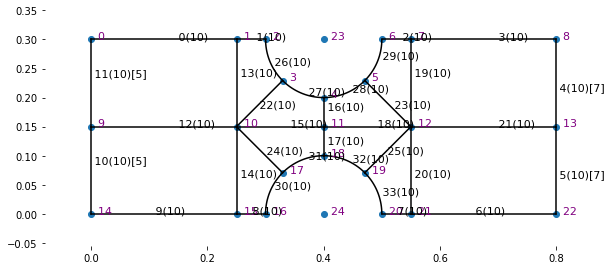

In [32]:
cfv.figure(fig_size=(10,10))
cfv.draw_geometry(g, draw_points=True, label_curves=True, label_points=True)

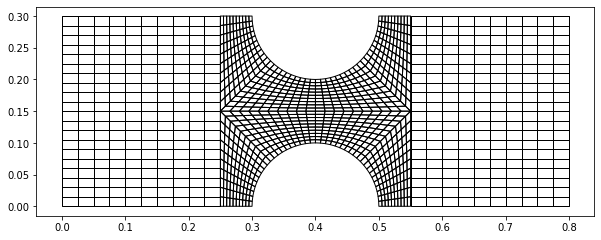

In [33]:
cfv.figure(fig_size=(10,10))
cfv.draw_mesh(coords, edof, dofs_per_node=mesh.dofs_per_node, el_type=mesh.el_type)

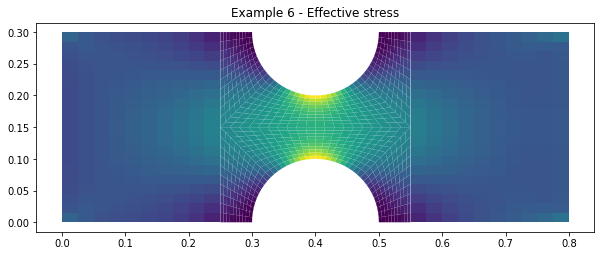

In [34]:
cfv.figure(fig_size=(10,10))
cfv.draw_element_values(vonMises, coords, edof, mesh.dofs_per_node, mesh.el_type, None, draw_elements=False, draw_undisplaced_mesh=False, title="Example 6 - Effective stress")

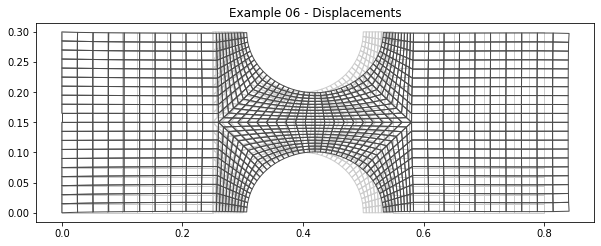

In [35]:
cfv.figure(fig_size=(10,10))
cfv.draw_displacements(a, coords, edof, mesh.dofs_per_node, mesh.el_type, draw_undisplaced_mesh=True, title="Example 06 - Displacements")